# 🧪 ToxPred Explainability Prototype

This notebook demonstrates the core concepts behind the ToxPred Explainable application:
- Molecular fingerprint generation
- Random Forest toxicity prediction
- Atom-level explainability using Morgan fingerprints
- Blood-Brain Barrier (BBB) permeability prediction

**Author:** Alex Batista  
**Date:** February 2026

## 1. Setup and Imports

In [1]:
# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# RDKit for molecular processing
from rdkit import Chem
from rdkit.Chem import AllChem, Draw, Descriptors
from rdkit.Chem.Draw import rdMolDraw2D

# Machine Learning
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

import warnings
warnings.filterwarnings('ignore')

print("✅ Libraries imported successfully!")

✅ Libraries imported successfully!


## 2. Molecular Fingerprints

Morgan fingerprints (ECFP) encode the local chemical environment around each atom. We use:
- **Radius = 2** (captures atoms up to 2 bonds away)
- **2048 bits** (vector size for ML model)

In [2]:
def get_morgan_fingerprint(smiles, radius=2, n_bits=2048):
    """Generate Morgan fingerprint from SMILES string."""
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=n_bits)
    return np.array(fp)

# Example: Aspirin
aspirin_smiles = "CC(=O)OC1=CC=CC=C1C(=O)O"
fp = get_morgan_fingerprint(aspirin_smiles)
print(f"Fingerprint shape: {fp.shape}")
print(f"Non-zero bits: {np.sum(fp)} / {len(fp)}")

Fingerprint shape: (2048,)
Non-zero bits: 24 / 2048


[14:58:28] DEPRECATION WARNING: please use MorganGenerator


## 3. Visualizing Molecules

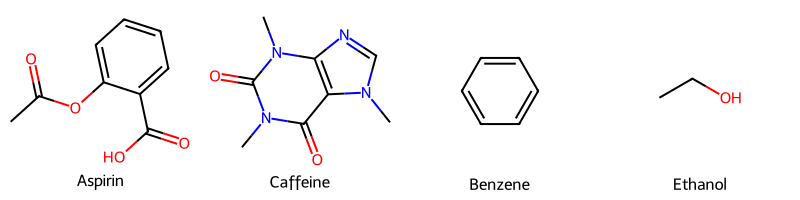

In [3]:
# Sample molecules for demonstration
molecules = {
    "Aspirin": "CC(=O)OC1=CC=CC=C1C(=O)O",
    "Caffeine": "CN1C=NC2=C1C(=O)N(C(=O)N2C)C",
    "Benzene": "C1=CC=CC=C1",
    "Ethanol": "CCO"
}

mols = [Chem.MolFromSmiles(smi) for smi in molecules.values()]
legends = list(molecules.keys())

img = Draw.MolsToGridImage(mols, molsPerRow=4, subImgSize=(200, 200), legends=legends)
img

## 4. Atom-Level Explainability

The key innovation in ToxPred is explaining **which atoms** contribute to toxicity predictions.

### How it works:
1. Generate Morgan fingerprint with `bitInfo` to track which atoms set which bits
2. Get feature importance from Random Forest
3. Map importance back to atoms through the bits they activate

In [4]:
def get_atom_contributions(smiles, feature_importances, radius=2, n_bits=2048):
    """
    Calculate contribution of each atom to the prediction.
    
    Returns: dict mapping atom_idx -> contribution score
    """
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return {}
    
    # Get fingerprint with bit info
    bit_info = {}
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=n_bits, bitInfo=bit_info)
    
    # Calculate atom contributions
    atom_contributions = {i: 0.0 for i in range(mol.GetNumAtoms())}
    
    for bit_idx, atoms_list in bit_info.items():
        importance = feature_importances[bit_idx]
        for atom_idx, radius in atoms_list:
            atom_contributions[atom_idx] += importance
    
    # Normalize
    max_contrib = max(atom_contributions.values()) if atom_contributions else 1
    if max_contrib > 0:
        atom_contributions = {k: v/max_contrib for k, v in atom_contributions.items()}
    
    return atom_contributions

# Demo with random importances
fake_importances = np.random.rand(2048)
contributions = get_atom_contributions(aspirin_smiles, fake_importances)
print("Atom contributions (normalized):")
for atom_idx, score in sorted(contributions.items(), key=lambda x: -x[1])[:5]:
    mol = Chem.MolFromSmiles(aspirin_smiles)
    atom = mol.GetAtomWithIdx(atom_idx)
    print(f"  Atom {atom_idx} ({atom.GetSymbol()}): {score:.3f}")

Atom contributions (normalized):
  Atom 10 (C): 1.000
  Atom 4 (C): 0.918
  Atom 8 (C): 0.908
  Atom 5 (C): 0.881
  Atom 0 (C): 0.720


[14:58:28] DEPRECATION WARNING: please use MorganGenerator


## 5. Generating Heatmap Visualization

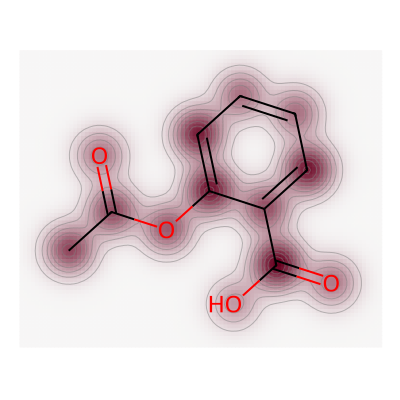

In [7]:
from rdkit.Chem.Draw import SimilarityMaps
from rdkit.Chem.Draw import rdMolDraw2D
from IPython.display import SVG, display

def draw_molecule_heatmap(smiles, atom_weights, size=(400, 400)):
    """
    Draw molecule with atom-level heatmap.
    Red = high contribution, Blue = low contribution
    """
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    
    # Prepare weights as list
    weights = [atom_weights.get(i, 0) for i in range(mol.GetNumAtoms())]
    
    # Create drawer for newer RDKit API
    drawer = rdMolDraw2D.MolDraw2DSVG(size[0], size[1])
    
    # Draw similarity map with drawer
    SimilarityMaps.GetSimilarityMapFromWeights(
        mol, weights, 
        colorMap='RdBu_r',
        draw2d=drawer
    )
    
    drawer.FinishDrawing()
    svg = drawer.GetDrawingText()
    
    return SVG(svg)

# Visualize aspirin with fake contributions
display(draw_molecule_heatmap(aspirin_smiles, contributions))

## 6. Lipinski's Rule of Five

Drug-likeness assessment based on:
- Molecular Weight ≤ 500 Da
- LogP ≤ 5
- H-bond donors ≤ 5
- H-bond acceptors ≤ 10

In [8]:
def calculate_lipinski(smiles):
    """Calculate Lipinski's Rule of Five properties."""
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    
    properties = {
        'MW': Descriptors.MolWt(mol),
        'LogP': Descriptors.MolLogP(mol),
        'HBD': Descriptors.NumHDonors(mol),
        'HBA': Descriptors.NumHAcceptors(mol),
        'TPSA': Descriptors.TPSA(mol),
        'RotBonds': Descriptors.NumRotatableBonds(mol)
    }
    
    # Check violations
    violations = 0
    if properties['MW'] > 500: violations += 1
    if properties['LogP'] > 5: violations += 1
    if properties['HBD'] > 5: violations += 1
    if properties['HBA'] > 10: violations += 1
    
    properties['Violations'] = violations
    properties['Drug-like'] = violations <= 1
    
    return properties

# Test on sample molecules
for name, smi in molecules.items():
    props = calculate_lipinski(smi)
    print(f"\n{name}:")
    print(f"  MW: {props['MW']:.1f}, LogP: {props['LogP']:.2f}")
    print(f"  HBD: {props['HBD']}, HBA: {props['HBA']}")
    print(f"  Drug-like: {'✅ Yes' if props['Drug-like'] else '❌ No'}")


Aspirin:
  MW: 180.2, LogP: 1.31
  HBD: 1, HBA: 3
  Drug-like: ✅ Yes

Caffeine:
  MW: 194.2, LogP: -1.03
  HBD: 0, HBA: 6
  Drug-like: ✅ Yes

Benzene:
  MW: 78.1, LogP: 1.69
  HBD: 0, HBA: 0
  Drug-like: ✅ Yes

Ethanol:
  MW: 46.1, LogP: -0.00
  HBD: 1, HBA: 1
  Drug-like: ✅ Yes


## 7. Blood-Brain Barrier (BBB) Prediction

The BBB model predicts whether a molecule can cross into the brain. Key factors:
- **Molecular weight** (smaller is better)
- **Lipophilicity** (LogP 1-3 optimal)
- **TPSA** (< 90 Å² preferred)
- **H-bond donors** (< 3 preferred)

In [9]:
def bbb_heuristic(smiles):
    """Simple heuristic for BBB permeability."""
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    
    mw = Descriptors.MolWt(mol)
    logp = Descriptors.MolLogP(mol)
    tpsa = Descriptors.TPSA(mol)
    hbd = Descriptors.NumHDonors(mol)
    
    # Scoring
    score = 0
    if mw < 450: score += 1
    if 1 < logp < 3: score += 1
    if tpsa < 90: score += 1
    if hbd < 3: score += 1
    
    return {
        'MW': mw,
        'LogP': logp,
        'TPSA': tpsa,
        'HBD': hbd,
        'BBB_Score': score,
        'Likely_Permeable': score >= 3
    }

# Test BBB permeability
bbb_molecules = {
    "Caffeine": "CN1C=NC2=C1C(=O)N(C(=O)N2C)C",  # BBB+
    "Dopamine": "NCCC1=CC(O)=C(O)C=C1",  # BBB-
    "Diazepam": "CN1C(=O)CN=C(C2=CC=CC=C2)C2=C1C=CC(Cl)=C2"  # BBB+
}

for name, smi in bbb_molecules.items():
    result = bbb_heuristic(smi)
    status = "🧠 Likely crosses BBB" if result['Likely_Permeable'] else "🚫 Unlikely to cross BBB"
    print(f"{name}: {status} (score: {result['BBB_Score']}/4)")

Caffeine: 🧠 Likely crosses BBB (score: 3/4)
Dopamine: 🚫 Unlikely to cross BBB (score: 2/4)
Diazepam: 🧠 Likely crosses BBB (score: 3/4)


## 8. Summary

This notebook demonstrated the core techniques used in ToxPred Explainable:

1. **Morgan Fingerprints** - Encode molecular structure as binary vectors
2. **Random Forest** - Classify molecules as toxic/non-toxic
3. **Atom Attribution** - Map feature importance back to specific atoms
4. **Heatmap Visualization** - Show which atoms drive predictions
5. **Lipinski Analysis** - Assess drug-likeness
6. **BBB Prediction** - Predict brain permeability

For the full interactive experience, run the Streamlit app:
```bash
streamlit run app.py
```